# Notebook to look at phase of b1 firing

## Imports

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data, cluster_spikes, save_processed_data, estimate_spike_rate
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar


In [40]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels|

## Helper functions

In [41]:
def make_cluster_plot(cluster_dict, spikes, spike_t, max_num_waveforms=200):
    """
    Little helper function to visualize clustering using cluster_dict, so we don't have to re-do it every time
    
    """
    # get range of cluster numbers
    range_n_clusters = [key for key in cluster_dict.keys() if str(key).isnumeric()]
    range_n_clusters = np.asarray(range_n_clusters)

    # read out silhouette scores
    silhouette_avgs = cluster_dict['silhouette_avgs']
    
    # initialize plotting tools
    n_rows = round(np.ceil(range_n_clusters.size/4))
    fig, ax_list = plt.subplots(n_rows, 4, figsize=(11, 9))
    ax_list = ax_list.ravel()

    for ith, n_clusters in enumerate(range_n_clusters):
        # read out cluster labels for current cluster number
        cluster_labels = cluster_dict[n_clusters]

        # get current cluster values and colors
        cluster_label_vals = np.unique(cluster_labels)
        colors = cm.tab10(cluster_label_vals.astype(float) / n_clusters)

         # reduce the number of waveforms we're plotting?
        for cval in cluster_label_vals:
            idx = (cluster_labels == cval)
            if np.sum(idx) > max_num_waveforms:
                ind = np.where(idx)[0][np.random.randint(0, np.sum(idx), max_num_waveforms)]
                idx = np.zeros_like(idx)
                idx[ind] = True

            # plot clustering in waveform space
            for spike in spikes[idx]:
                ax_list[ith].plot(spike_t, spike, color=colors[cval], lw=0.35, alpha=0.2)
        
        # set axis labels
        ax_list[ith].autoscale(enable=True, axis='x', tight=True)
        # ax_list[ith].set_xlabel('time (ms)', fontsize=20);
        ax_list[ith].set_ylabel('emg (V)', fontsize=12);
        ax_list[ith].set_title('clustering for n={}'.format(n_clusters), fontsize=14)

    # add final plot for silhouette scores
    ax_list[-1].plot(range_n_clusters, silhouette_avgs)
    ax_list[-1].set_xlabel('Number of clusters', fontsize=12)
    ax_list[-1].set_ylabel('Silhouette score', fontsize=12)
    ax_list[-1].set_title('Silhouette score vs cluster count')

    fig.tight_layout()

    return fig, ax_list
    

## Load data

In [59]:
# load data file
data_folder = 50
axo_num = 15 # 4

# try:
#     data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
#     print('loaded spikes file')
# except ValueError:
#     data = load_processed_data(data_folder, axo_num, data_suffix='_processed')
data = load_processed_data(data_folder, axo_num, data_suffix='_processed')


In [60]:
# read out data fields
t = data['time']
emg = data['emg']
wbf = data['wbf']
spike_idx = data['spike_idx']
spikes = data['spikes']
spike_t = data['spike_t']
mic_phase = data['mic_phase']
# cluster_dict = data['cluster_dict']

window = data['params']['emg_window']


In [44]:
# set plot params
# PLOT PARAMETERS
plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)


In [45]:
data['params']

{'nperseg': 16384,
 'notch_q': 2.0,
 'min_spike_dt': 0.0005,
 'recenter_window_factor': 1.0,
 'remove_edge_case_flag': False,
 'mic_lowcut': 200,
 'mic_highcut': 850,
 'emg_lowcut': 300,
 'emg_highcut': 10000,
 'emg_btype': 'bandpass',
 'emg_window': 32,
 'emg_offset': 4,
 'thresh_factors': (0.55, 4)}

## Look at spikes

In [46]:
# # TEMP: what does this look like with raw spikes
# spikes_raw = []
# for idx in spike_idx:
#     idx_range = np.arange(idx - window, idx + window)
#     spike = emg[idx_range]
#     spike -= np.mean(spike)
#     spikes_raw.append(spike)

# spikes_raw = np.vstack(spikes_raw)
# spikes = spikes_raw

Text(0, 0.5, 'emg (V)')

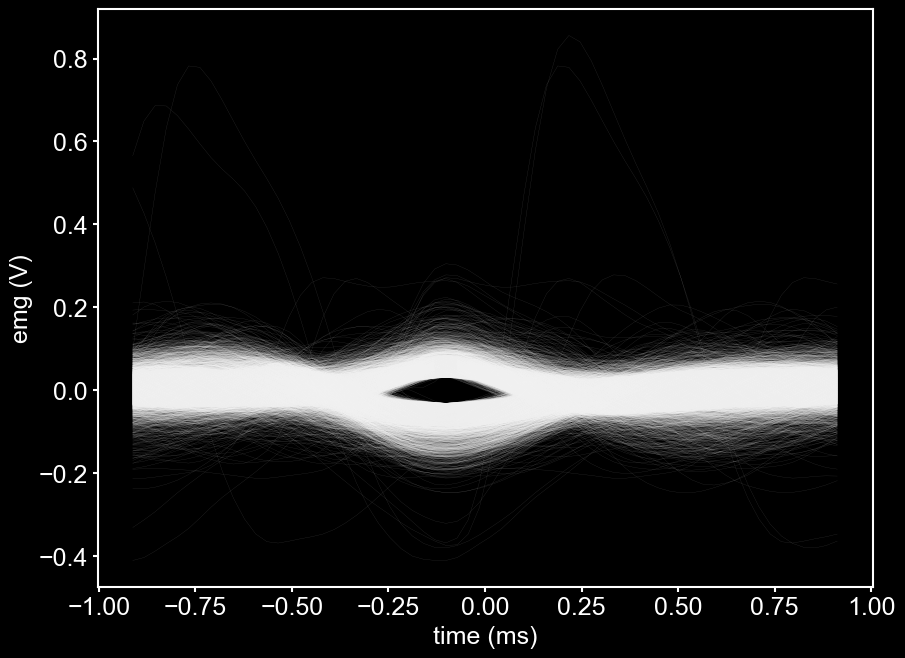

In [47]:
# quick visualization of spikes
fig, ax= plt.subplots()

for spike in spikes:
    ax.plot(1000*spike_t, spike, 'w-', alpha=0.2, lw=0.2)

ax.set_xlabel('time (ms)')
ax.set_ylabel('emg (V)')


## Need to sort out real spikes from noise

For n_clusters = 2 The average silhouette_score is : 0.5228251394923462
For n_clusters = 3 The average silhouette_score is : 0.36495841381128497
For n_clusters = 4 The average silhouette_score is : 0.35111122724516736
For n_clusters = 5 The average silhouette_score is : 0.3515383650055597
For n_clusters = 6 The average silhouette_score is : 0.352688079832513
For n_clusters = 7 The average silhouette_score is : 0.30987982529152347
For n_clusters = 8 The average silhouette_score is : 0.3039326353993065


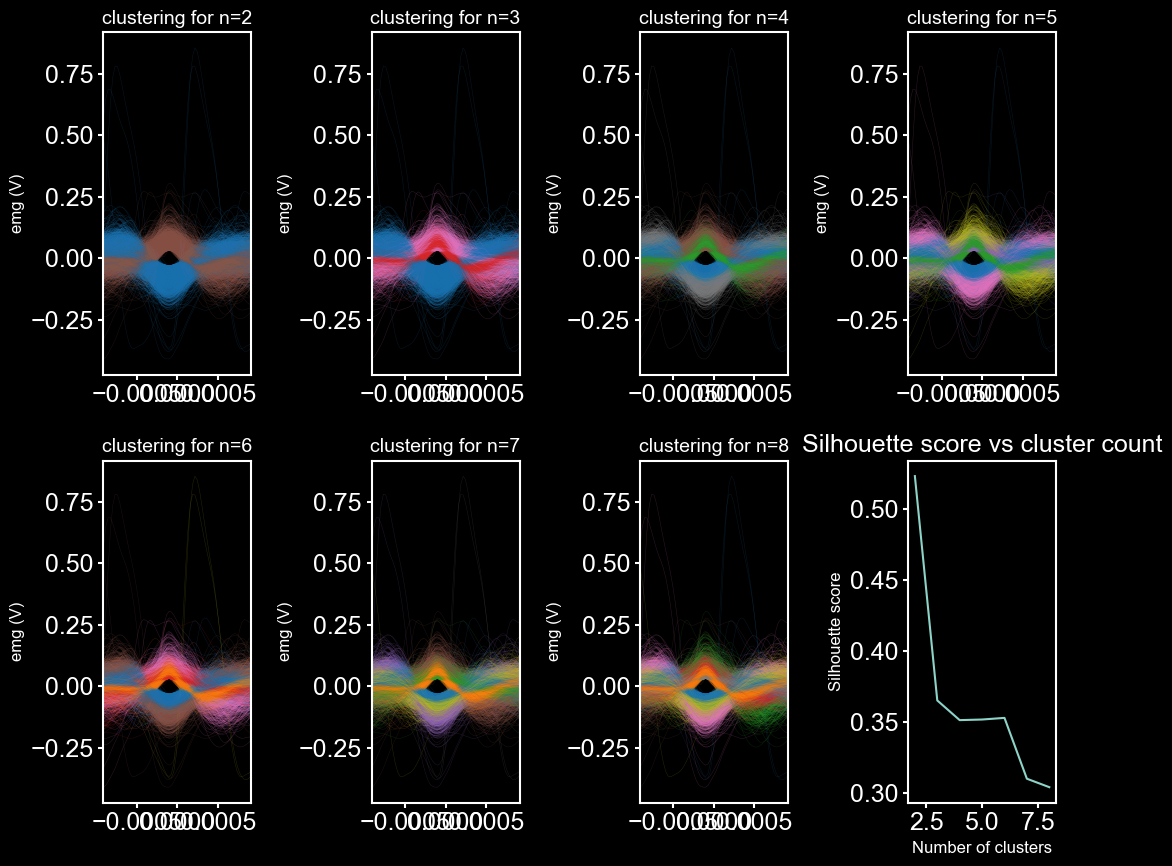

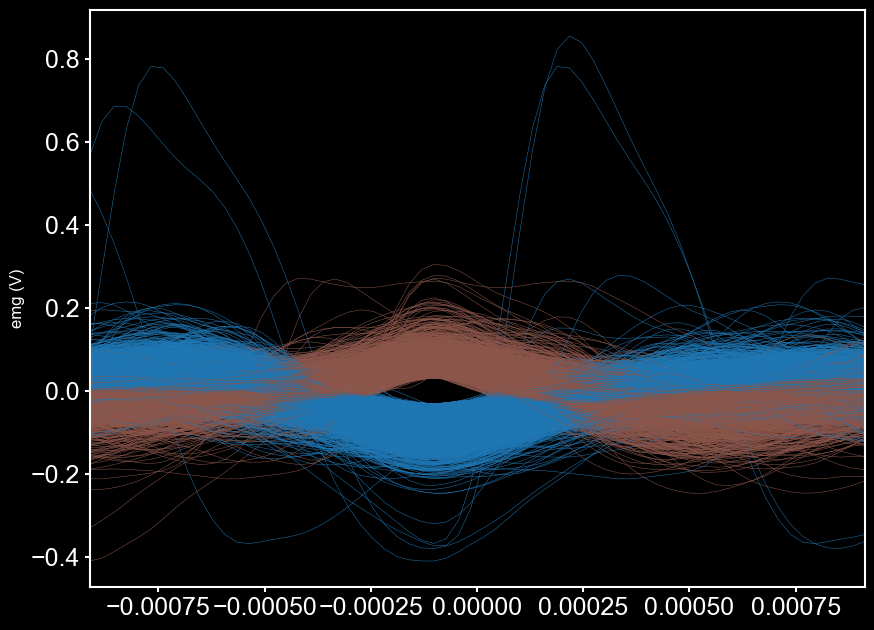

In [48]:
# do clustering
cluster_labels, cluster_dict = cluster_spikes(spikes, spike_t=spike_t, viz_flag=True)


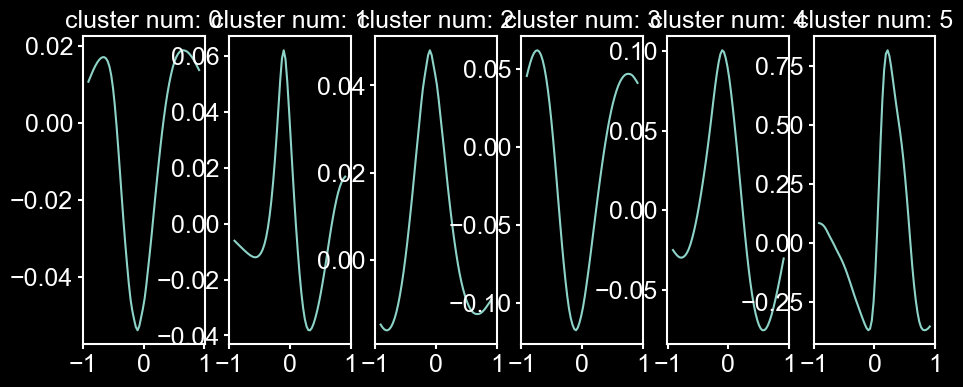

In [61]:
# looks like clustering into 2 groups does the trick. check which number is which and grab the right cluster
# cluster_labels = cluster_spikes(spikes, spike_t=spike_t, viz_flag=True, cluster_num=4)
cluster_labels = cluster_dict[6]
cluster_nums = np.unique(cluster_labels)

fig, ax_list = plt.subplots(1, cluster_nums.size, figsize=(11, 4))
ax_list = ax_list.ravel()

for ith, cnum in enumerate(cluster_nums):
    clust_idx = (cluster_labels == cnum)
    cluster_mean = np.mean(spikes[clust_idx, :], axis=0)
    
    ax_list[ith].plot(1000*spike_t, cluster_mean)
    ax_list[ith].set_title(f'cluster num: {cnum}')
    

In [62]:
# in my case, cluster 0 is the right one, but this will vary. take only these values
good_cluster = 1  # [0, 1]  # 1  # [0, 1]

if type(good_cluster) is list:
    keep_ind = np.any(np.vstack([cluster_labels == gc for gc in good_cluster]), axis=0)
    
else:
    keep_ind = (cluster_labels == good_cluster)
    
spikes = spikes[keep_ind]
spike_idx = spike_idx[keep_ind] 


Text(0, 0.5, 'emg (V)')

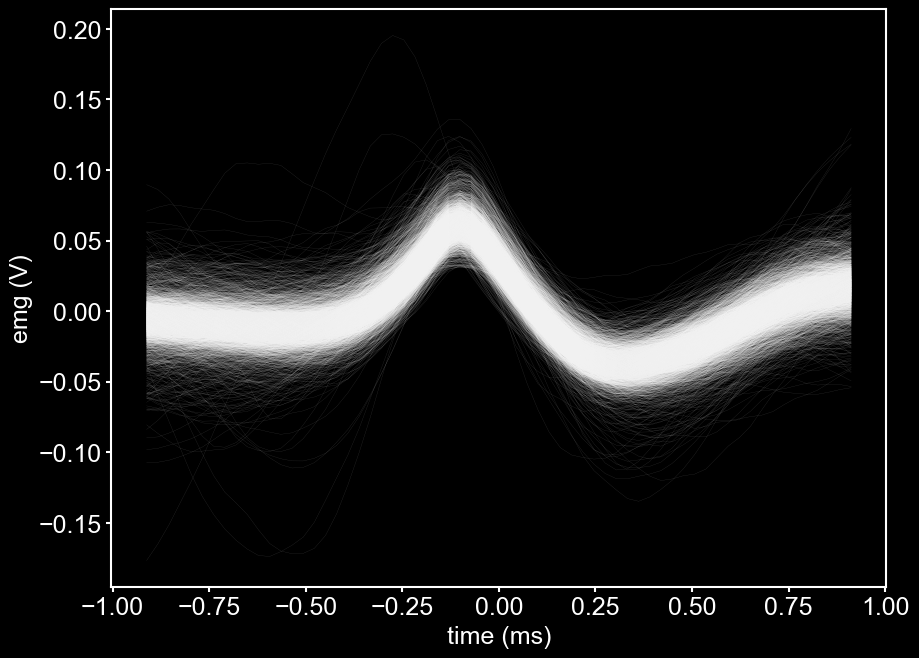

In [63]:
# check that we did that right with a quick visualization of spikes
fig, ax = plt.subplots()

for spike in spikes:
    ax.plot(1000*spike_t, spike, 'w-', alpha=0.2, lw=0.2)

ax.set_xlabel('time (ms)')
ax.set_ylabel('emg (V)')


## Save data file with "good spikes" identified

In [64]:
# add fields to dict
data['good_spikes'] = spikes
data['good_spike_idx'] = spike_idx


In [66]:
# get save path for this file
abf_filename = data['filename']
save_filename = abf_filename.replace('.abf', '_spikes.pkl')
print(save_filename)

/media/sam/SamData/Mosquitoes/50_20240816/2024_08_16_0015/2024_08_16_0015_spikes.pkl


In [67]:
# save 
save_processed_data(save_filename, data)

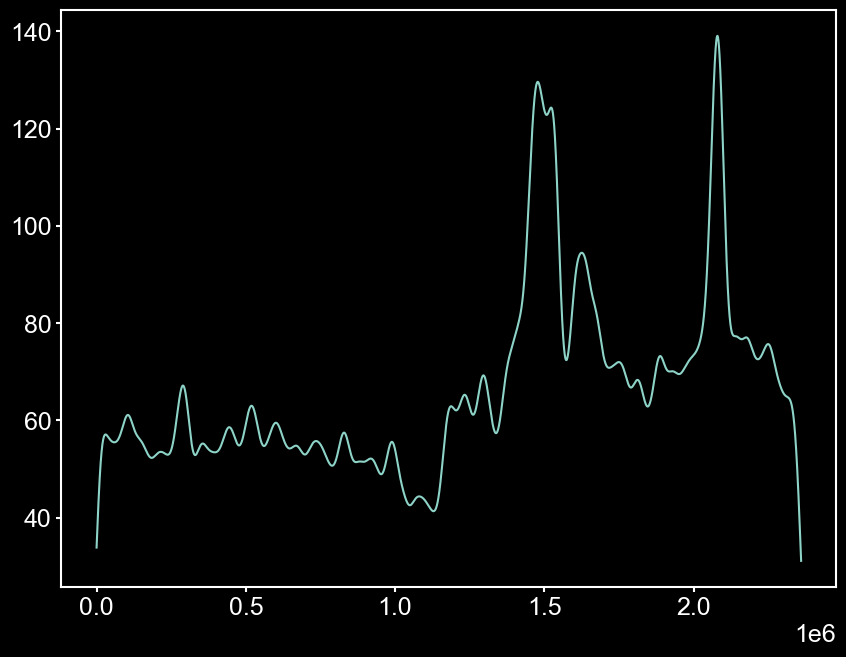

In [68]:
spike_rate = estimate_spike_rate(spike_idx, data['sampling_freq'], t.size, win_factor=2*8)
plt.plot(spike_rate)

## make phase plots

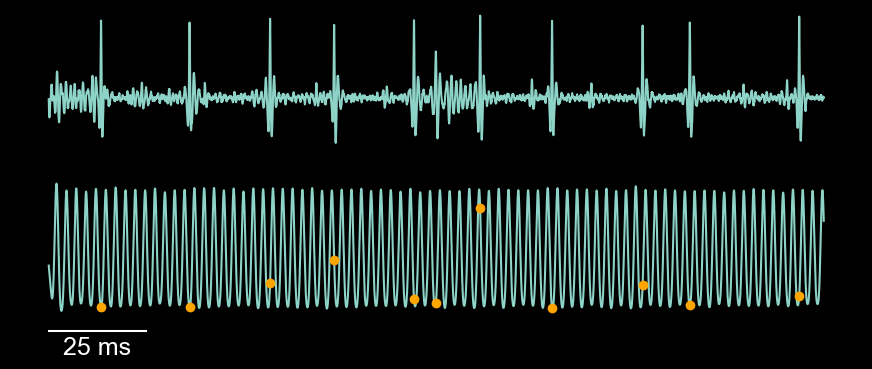

In [235]:
# pull out mic phase at spike times
# read out data fields
from mosquito.util import my_adjust_axes, my_add_scalebar

t = data['time']
try:
    spike_idx = data['good_spike_idx']
except KeyError:
    spike_idx = data['spike_idx']
mic_phase = data['mic_phase']
emg_filt = data['emg_filt']
mic_filt = data['mic_filt']

mic_phase_at_spike = mic_phase[spike_idx]

# time range to plot
tmin = 0
tmax = 0.2
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx]  >= tmin) & (t[spike_idx]  <= tmax)

fig, (ax0, ax1) = plt.subplots(2,1,figsize=(11,4), sharex=True)

ax0.plot(t[mask], emg_filt[mask])

ax1.plot(t[mask], mic_filt[mask])
ax1.plot(t[spike_idx][mask_spikes], mic_filt[spike_idx][mask_spikes], 'o', color='orange')

# remove axis lines from each plot
ax0 = my_adjust_axes(ax0, keep_spines=['none'])
ax1 = my_adjust_axes(ax1, keep_spines=['bottom'])

# add scalebar to bottom plot
ax1 = my_add_scalebar(ax1, (tmin, tmin+0.025) , units='ms', label_mult_factor=1000)

## Recalculate spike rate

Text(0, 0.5, 'emg (V)')

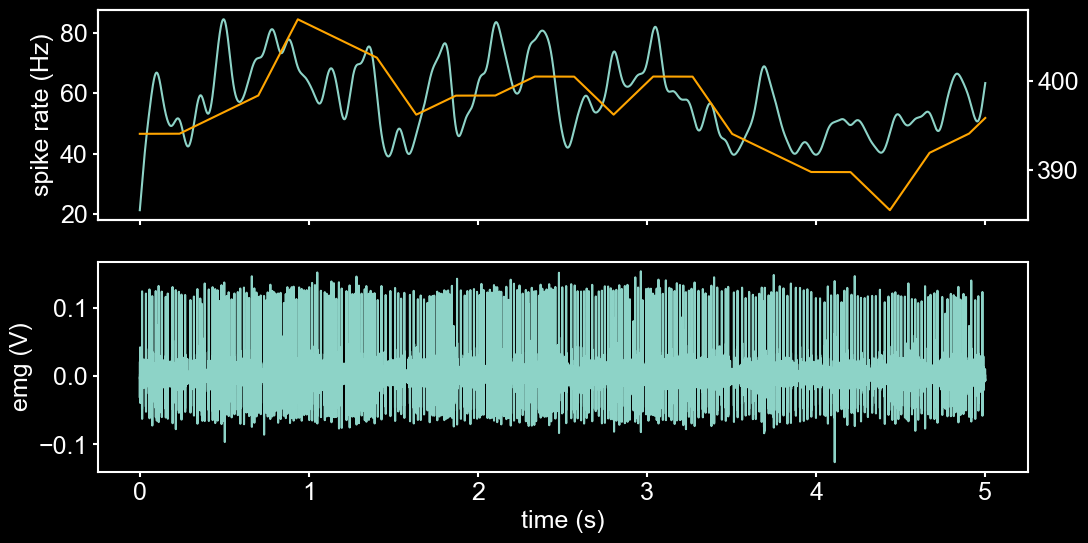

In [240]:
from mosquito.process_abf import estimate_spike_rate
from mosquito.util import my_adjust_axes, my_add_scalebar

# read out data
t = data['time']
fs = data['sampling_freq']
emg_filt = data['emg_filt']
wbf = data['wbf']
try:
    spike_idx = data['good_spike_idx']
except KeyError:
    spike_idx = data['spike_idx']

# get length of data array
n_pts = t.size

# estimate spike rate
spike_rate = estimate_spike_rate(spike_idx, fs, n_pts)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)

tmin = 0
tmax = 5
mask = (t >= tmin) & (t <= tmax)

ax1.plot(t[mask], spike_rate[mask])
ax1.set_ylabel('spike rate (Hz)')

ax11 = ax1.twinx()
ax11.plot(t[mask], wbf[mask], color='orange')

ax2.plot(t[mask], emg_filt[mask])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('emg (V)')


## Incorporate mic phase

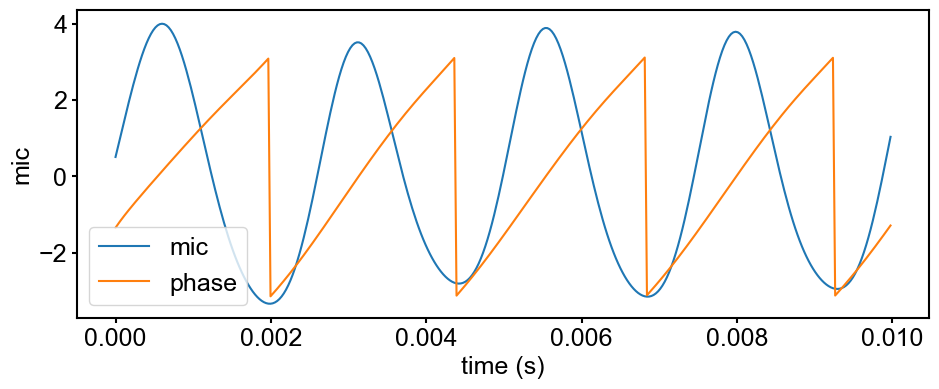

In [58]:
# look at mic data
fig, ax = plt.subplots(figsize=(11,4))

tmin = 0
tmax = 0.01
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], data['mic_filt'][mask], label='mic')
ax.plot(t[mask], mic_phase[mask], label='phase')
# ax.plot( mic_phase[mask], data['mic_filt'][mask])

ax.set_xlabel('time (s)')
ax.set_ylabel('mic')
plt.legend()

Text(0, 0.5, 'pdf')

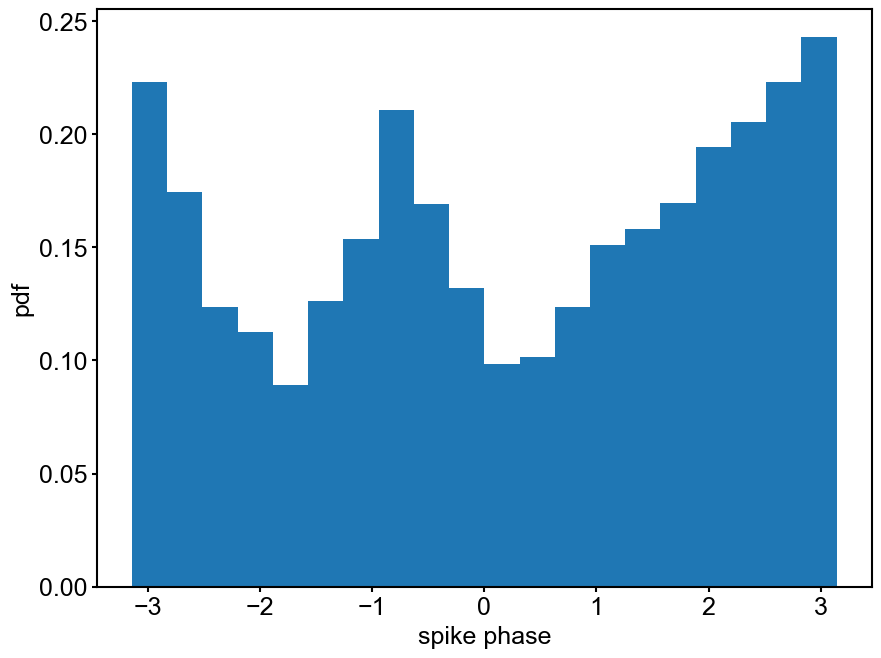

In [59]:
# pull out mic phase at spike times
mic_phase_at_spike = mic_phase[spike_idx]

# visualize with histogram
fig, ax = plt.subplots()

ax.hist(mic_phase_at_spike, bins=20, density=True)

ax.set_xlabel('spike phase')
ax.set_ylabel('pdf')


In [ ]:
# # 48.2, 50.6, 50.15
# data_folders = [48, 50, 50]
# axo_nums = [2, 6, 15]
# vector_strengths = list()

# for data_folder, axo_num in  zip(data_folders, axo_nums):
#     # load data
#     data = load_processed_data(...)

#     # do the vector strenght extraction
#     # ...

#     # store
#     vector_strengths.append(output)

# # now make this into a dict
# vector_strength_dict = dict()
# vector_strength_dict['data_folder'] = data_folders
# vector_strength_dict['axo_nums'] = axo_nums
# vector_strength_dict['vector_strengths'] = vector_strengths


## Make figure showing spike phase histogram

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_726618/3778292898.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['-$\pi$', '$\pi$'])
/tmp/ipykernel_726618/3778292898.py:20: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['-$\pi$', '$\pi$'])


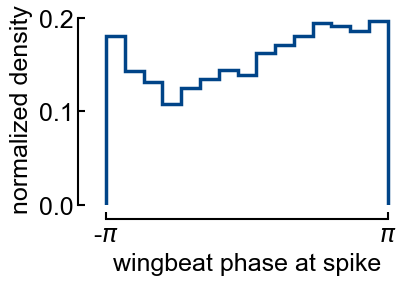

In [14]:
# make a kde plot for phase at spike
from sklearn.neighbors import KernelDensity

phase_range = np.linspace(-np.pi, np.pi, 150)
mosquito_female_color = '#004488'

# make figure
fig, ax = plt.subplots(figsize=(4,2.5))

# do KDE
# kde = KernelDensity(kernel="gaussian", bandwidth=0.35).fit(mic_phase_at_spike.reshape(-1, 1))
# log_dens = kde.score_samples(phase_range.reshape(-1, 1))
# ax.plot(phase_range, np.exp(log_dens), color=mosquito_female_color, lw=1.5)
ax.hist(mic_phase_at_spike, bins=15, density=True, color=mosquito_female_color, lw=2.5, histtype='step')  # 

# adjust axes
ax.set_ylabel('normalized density')
ax.set_xlabel('wingbeat phase at spike')
ax.set_xticks([-np.pi, np.pi])
ax.set_xticklabels(['-$\pi$', '$\pi$'])
ax = my_adjust_axes(ax)

# save
save_flag=False
if save_flag:
    save_path = '/media/sam/SamData/Dropbox/Conferences/ICN 2024/poster/figs'
    save_name = 'b1_phase_hist.svg'
    fig.savefig(os.path.join(save_path, save_name),  dpi=500, bbox_inches='tight')